In [4]:
!pip install tensorflow
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [5]:
import numpy as np
import gzip
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from google.colab import drive
from keras_tuner import RandomSearch

In [6]:
drive.mount('/content/drive')

def load_images(images_path):
    with gzip.open(images_path, 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16)
        images = images.reshape(-1, 28, 28, 1)
    return images

def load_labels(labels_path):
    with gzip.open(labels_path, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels

train_images_path = '/content/drive/My Drive/train-images-idx3-ubyte.gz'
train_labels_path = '/content/drive/My Drive/train-labels-idx1-ubyte.gz'
test_images_path = '/content/drive/My Drive/t10k-images-idx3-ubyte.gz'
test_labels_path = '/content/drive/My Drive/t10k-labels-idx1-ubyte.gz'

train_images = load_images(train_images_path)
train_labels = load_labels(train_labels_path)
test_images = load_images(test_images_path)
test_labels = load_labels(test_labels_path)

Mounted at /content/drive


In [7]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [8]:
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [9]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [10]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='intro_to_kt')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
tuner.search(train_images, train_labels, epochs=10, validation_split=0.2)

Trial 3 Complete [00h 01m 18s]
val_accuracy: 0.8870000243186951

Best val_accuracy So Far: 0.8870000243186951
Total elapsed time: 00h 05m 06s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
448               |128               |units
0.5               |0.1               |dropout

Epoch 1/10
 566/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6832 - loss: 0.8902

KeyboardInterrupt: 

In [12]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

In [13]:
history = model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7450 - loss: 0.7263 - val_accuracy: 0.8506 - val_loss: 0.4187
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8556 - loss: 0.4116 - val_accuracy: 0.8547 - val_loss: 0.4008
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8667 - loss: 0.3733 - val_accuracy: 0.8725 - val_loss: 0.3589
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8750 - loss: 0.3446 - val_accuracy: 0.8767 - val_loss: 0.3478
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8826 - loss: 0.3241 - val_accuracy: 0.8748 - val_loss: 0.3382
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8848 - loss: 0.3113 - val_accuracy: 0.8804 - val_loss: 0.3268
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8892 - loss: 0.2961 - val_accuracy: 0.8827 - val_loss: 0.3298
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8952 - loss: 0.2838 - val_accuracy: 0.

In [14]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc}')

313/313 - 1s - 2ms/step - accuracy: 0.8791 - loss: 0.3436
Test accuracy: 0.8791000247001648


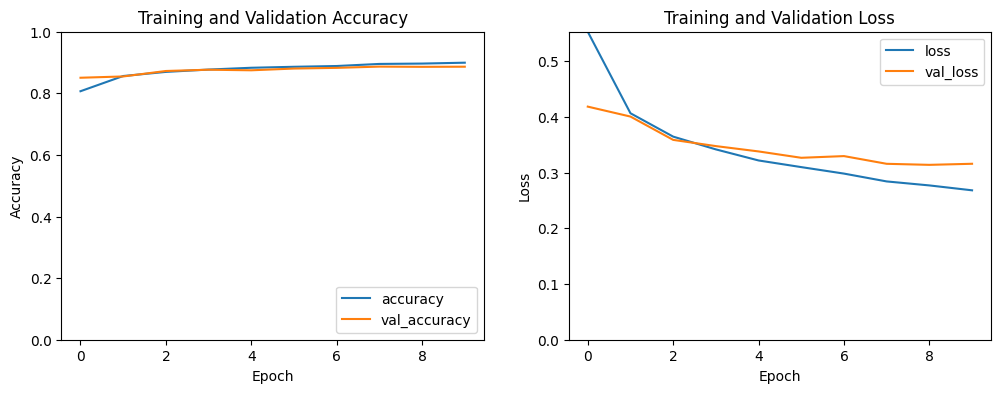

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(history.history['loss'])])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


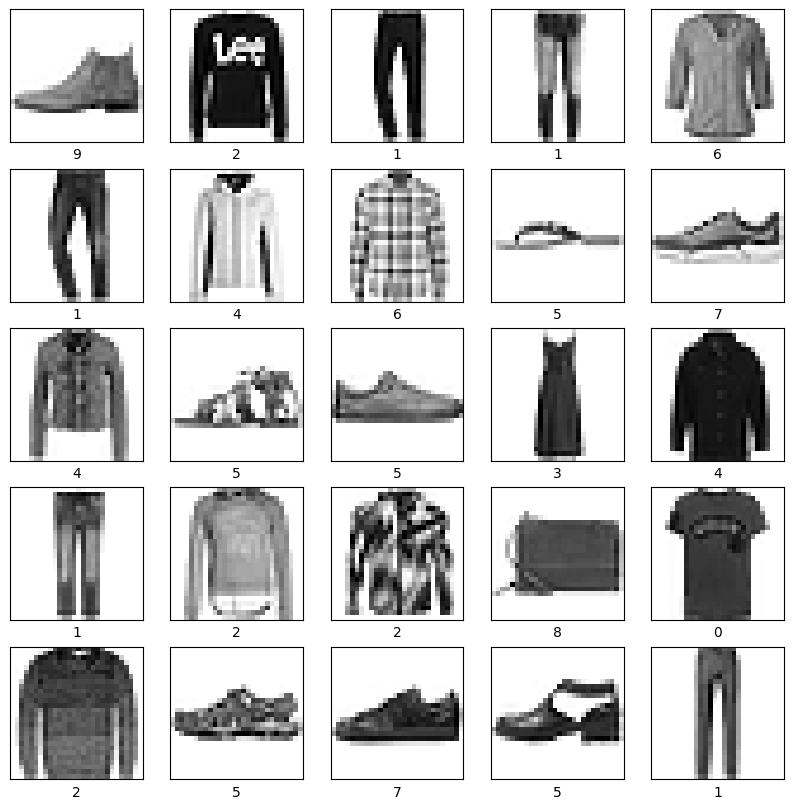

In [16]:
predictions = model.predict(test_images)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(np.argmax(predictions[i]))
plt.show()

In [17]:
model.save('fashion_mnist_model.h5')